In [1]:
### Imports ####################################################################
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, GRU
from typing import Tuple, Callable, List, Optional
from tracker import visuals, extractor, utils, metrics

np.set_printoptions(suppress=True)
Tensor = theano.tensor.Tensor

Using Theano backend.


In [2]:
### File Writers ###############################################################
def write4d(file, array: np.ndarray) -> None:
    for cube in array:
        for matrix in cube:
            for row in matrix:
                for number in row:
                    string = "{0: >6.2f} | ".format(number)
                    string = string.replace("-0.00", "     ")
                    string = string.replace( "0.00",  "    ")
                    file.write(string)
                file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write3d(file, array: np.ndarray) -> None:
    for matrix in array:
        for row in matrix:
            for number in row:
                string = "{0: >6.2f} | ".format(number)
                string = string.replace("-0.00", "     ")
                string = string.replace( "0.00",  "    ")
                file.write(string)
            file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write(filename: str, array: np.ndarray) -> None:
    with open(filename, "w") as file:
        if len(array.shape) == 4:
            write4d(file, array)
        elif len(array.shape) == 3:
            write3d(file, array)
        else:
            file.write(str(array))

In [3]:
### Load in Data ###############################################################
order  = ["phi", "r", "z"]
frame  = pd.read_csv("data/sets/ACTS-SMALL-PREPARED.gz")
data   = extractor.extract_input(frame, order)
matrix = extractor.extract_output(frame, order)
input_shape  = data.shape[1:]
output_shape = matrix.shape[1:]
print(len(data))
print(input_shape)
print(output_shape)
n = 3
#visuals.display_matrices(data[1], matrix[n], order=order, noise=False)

19
(50, 3)
(50, 12)


In [4]:
#### LossFunctionCreator #######################################################
class LossFunctionCreator:
    def __init__(self,
            input_tensor : Tensor,
            input_shape  : Tuple,
            output_shape : Tuple,
            order        : List[str],
            ) -> None:
        """ Initialize the instance variables. """
        self.__name__     = "LossFunctionCreator"
        self.input_tensor = input_tensor
        self.meshgrid     = self.make_meshgrid(output_shape)
        self.input_shape  = input_shape
        self.output_shape = output_shape
        self.order        = order

    def make_meshgrid(self,
            shape : Tuple[int, int],
            ) -> Tensor:
        """
        Create a meshgrid.
        Example for shape (3, 5):
            [[0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4]]
        """
        return (T.mgrid[0:shape[0], 0:shape[1]][1])
    
    def combine_with_input_tensor(self,
            input_tensor  : Tensor,
            output_tensor : Tensor,
            ) -> Tensor:
        """
        Return the cartesian product of the input_tensor and the
        output_tensor along the last two axes.
        """
        input_list   = [input_tensor  for _ in range(self.output_shape[-1])]
        output_list  = [output_tensor for _ in range(self.input_shape[-1])]
        input_stack  = T.stack(input_list,  axis=-1)
        output_stack = T.stack(output_list, axis=-2)
        return input_stack * output_stack
    
    def combo_loss(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        """ A loss function. Temporary. """
        input_tensor = self.to_std_dist(self.input_tensor, axis=1)
        true_combo   = self.combine_with_input_tensor(input_tensor, y_true)
        pred_combo   = self.combine_with_input_tensor(input_tensor, y_pred)
        diff_squared = (pred_combo - true_combo)**2
        return diff_squared
    
    def regression_loss(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        input_tensor = self.input_tensor
        # input_tensor = self.to_std_dist(self.input_tensor, axis=1)
        tensor = None
        for i in range(output_shape[1]):  # For each track...
            pred_mask = self.get_track_mask(y_pred, i)
            true_mask = self.get_track_mask(y_true, i)
            
            pred_num_hits = pred_mask.sum(-1).sum(-1) + 2  # Avoid Div(0).
            true_num_hits = true_mask.sum(-1).sum(-1) + 2  # Avoid Div(0).
            
            pred_masked = pred_mask * input_tensor
            true_masked = true_mask * input_tensor
            
            pred_line = self.linear_regression(pred_masked, pred_num_hits)
            true_line = self.linear_regression(true_masked, true_num_hits)
            
            diff   = (pred_line - true_line)**2
            tensor = diff if tensor is None else tensor + diff
        return (tensor / self.output_shape[1])
    
    def to_std_dist(self,
            tensor : Tensor,
            axis   : int,
            ) -> Tensor:
        """
        Transform the tensor's values to be the number of standard deviations
        that the value is from the mean along the specified axis.
        """
        mean = tensor.mean(axis=axis, keepdims=True)
        std  = tensor.std(axis=axis, keepdims=True)
        return (tensor - mean) / std
    
    def softmax(self,
            tensor     : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the softmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        exponent = (refinement * tensor).exp()
        return exponent / exponent.sum(axis=axis, keepdims=True)

    def softargmax(self,
            tensor     : Tensor,
            indices    : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the argsoftmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        return (self.softmax(tensor, axis, refinement) * indices).sum(axis=axis)
    
    def get_order_mask(self,
            string : str,
            ) -> Tensor:
        """
        Return a mask such that when output is multiplied by this mask,
        only the column corresponding to the *string* category remains.
        """
        mask = np.zeros(len(self.order))
        mask[self.order.index(string)] = 1
        return T.as_tensor_variable(mask)
    
    def get_track_mask(self,
            output   : Tensor,
            track_id : int,
            aref     : int = 512,  # Refinement value for softargmax.
            mref     : int =   5,  # Refinement value for mask values.
            ) -> Tensor:
        """
        Retrieve a tensor containing a mask such that if self.tensor_input
        was multiplied by the mask, the result would be a tensor containing
        the positions of all hits with the specified track_id.
        """
        cats = self.softargmax(output, self.meshgrid, refinement=aref, axis=-1)
        fill = T.fill(cats, track_id)
        diff = (cats - fill)**2
        mask = 1 / (mref * diff).exp()
        mask = mask.reshape((*T.shape(mask), 1))
        return mask
    
    def linear_regression(self,
            tensor : Tensor,
            length : Tensor,
            ) -> Tensor:
        """
        Given a tensor, and the number of hits within the tensor,
        return the two parameters (m, b) of the least squares
        regression line with equation f[x] = (m * x) + b.
        """
        e = 2 * K.common.epsilon()  # Epsilon to avoid division by 0.
        p = (tensor * self.get_order_mask("phi")).sum(-1)
        r = (tensor * self.get_order_mask("r")).sum(-1)  # r values.
        z = (tensor * self.get_order_mask("z")).sum(-1)  # z values.
        
        d = (length * (r**2).sum(-1)) - r.sum(-1)**2 + e  # Denominator.
        m = (length * (r * z).sum(-1) - r.sum(-1) * z.sum(-1)) / d
        b = (z.sum(-1) * (r**2).sum(-1) - r.sum(-1) * (r * z).sum(-1)) / d
        return m #T.stack([m, b]).T
    
    def __call__(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        """ Return a Tensor that measures the loss of a model. """
        return self.regression_loss(y_true, y_pred)
    
A = T.tensor3("A")
B = T.tensor3("B")
C = T.tensor3("C")
D = LossFunctionCreator(A, input_shape, output_shape, order)
E = D(B, C)
F = theano.function([A, B, C], E, on_unused_input='ignore')
#print(theano.printing.debugprint(E))
positions   = data  [0:5]
true_matrix = matrix[0:5]
pred_matrix = np.random.rand(*true_matrix.shape)
pred_matrix = pred_matrix / pred_matrix.sum(-1, keepdims=True)
evaluation = F(positions, true_matrix, pred_matrix).round(2)
print(evaluation)
write("output4.txt", evaluation)

[ 14.9    6.36  20.93  19.11  23.16]


In [5]:
### Define Model ###############################################################
# Input Layer:
input_layer = Input(
    name  = "Input", 
    shape = input_shape,
)

model_layer = GRU(
    name = "GRU 1",
    return_sequences = True,
    units = 256,
)(input_layer)
model_layer = GRU(
    name = "GRU 2",
    return_sequences = True,
    units = 256,
)(model_layer)
model_layer = GRU(
    name = "GRU 3",
    return_sequences = True,
    units = 256,
)(model_layer)

# Output Layer:
output_layer = Dense(
    name  = "Softmax",
    units = output_shape[1],
    activation = "softmax",
    kernel_initializer = "uniform",
)(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
loss  = LossFunctionCreator(input_layer, input_shape, output_shape, order)
opt   = keras.optimizers.RMSprop(lr=0.000001)
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 50, 3)             0         
_________________________________________________________________
GRU 1 (GRU)                  (None, 50, 256)           199680    
_________________________________________________________________
GRU 2 (GRU)                  (None, 50, 256)           393984    
_________________________________________________________________
GRU 3 (GRU)                  (None, 50, 256)           393984    
_________________________________________________________________
Softmax (Dense)              (None, 50, 12)            3084      
Total params: 990,732
Trainable params: 990,732
Non-trainable params: 0
_________________________________________________________________


In [8]:
### Fit Model ##################################################################
histories = model.fit(
    data, 
    matrix, 
    epochs=50, 
    batch_size=1,
    verbose=2, 
    validation_data=(data, matrix)
)
predictions = model.predict(data[0:2])
write("output.txt", predictions)

Train on 19 samples, validate on 19 samples
Epoch 1/50
4s - loss: 19.1096 - acc: 0.2421 - val_loss: 19.0164 - val_acc: 0.2421
Epoch 2/50
4s - loss: 19.5866 - acc: 0.2421 - val_loss: 19.1449 - val_acc: 0.2400
Epoch 3/50
4s - loss: 19.1201 - acc: 0.2400 - val_loss: 18.9078 - val_acc: 0.2411
Epoch 4/50
4s - loss: 27.4329 - acc: 0.2411 - val_loss: 19.3564 - val_acc: 0.2453
Epoch 5/50
4s - loss: 19.3524 - acc: 0.2453 - val_loss: 19.2618 - val_acc: 0.2453
Epoch 6/50
4s - loss: 19.2583 - acc: 0.2453 - val_loss: 19.1817 - val_acc: 0.2453
Epoch 7/50
4s - loss: 19.1816 - acc: 0.2453 - val_loss: 19.0917 - val_acc: 0.2453
Epoch 8/50
4s - loss: 19.0958 - acc: 0.2453 - val_loss: 18.9750 - val_acc: 0.2453
Epoch 9/50
4s - loss: 18.9612 - acc: 0.2453 - val_loss: 18.8703 - val_acc: 0.2453
Epoch 10/50
4s - loss: 18.8510 - acc: 0.2453 - val_loss: 18.6384 - val_acc: 0.2421
Epoch 11/50
4s - loss: 18.7269 - acc: 0.2421 - val_loss: 19.0396 - val_acc: 0.2421
Epoch 12/50
4s - loss: 19.1938 - acc: 0.2432 - val_l

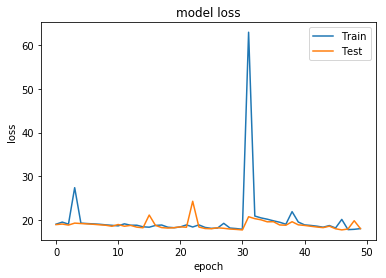

In [9]:
#### Graph Loss ################################################################
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

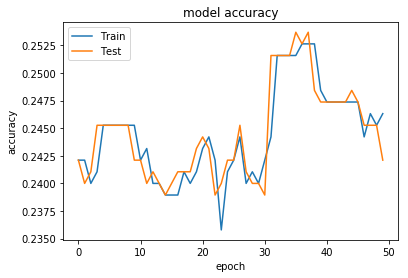

In [10]:
#### Graph Accuracy ############################################################
plt.plot(histories.history['acc'])
plt.plot(histories.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [1]:
print("hi")

hi


In [20]:
################################################################################
class Solver:
    def __init__(self, puzzle: np.ndarray, answer: np.ndarray) -> None:
        self.puzzle = puzzle
        self.answer = answer
        self.zero   = np.stack(np.where(puzzle == 0), axis=-1)[0]
    
    def __str__(self) -> str:
        string = str(self.puzzle)
        string = string.replace(" 0 ", "   ")
        string = string.replace("[0 ", "[  ")
        string = string.replace(" 0]", "  ]")
        return string
        
    def is_solved(self) -> bool:
        return np.array_equal(self.puzzle, self.answer)
    
    def go(self, direction: Tuple[int, int]) -> None:
        """ Move the puzzle's zero in the direction by swapping cells. """
        position = self.clip(self.zero + np.array(direction))
        self.swap(self.zero, position)
        self.zero = direction
    
    def clip(self, index: Tuple[int, int]) -> np.ndarray:
        """ Clip index to be within the puzzle's dimensions. """
        minimum = np.zeros(shape=index.shape)
        maximum = np.array(self.answer.shape) - 1
        return np.clip(index, minimum, maximum).astype(int)
    
    def swap(self, t1: Tuple[int, int], t2: Tuple[int, int]) -> None:
        """ Swap the values at index t1 and index t2 within self.puzzle. """
        p = self.puzzle
        p[t1[0], t1[1]], p[t2[0], t2[1]] = p[t2[0], t2[1]], p[t1[0], t1[1]]
    
np.random.seed(7)
shape  = np.array([4, 4])
values = np.arange(np.prod(shape))
puzzle = np.random.permutation(values).reshape(shape)
answer = np.roll(values, -1).reshape(shape)
solver = Solver(puzzle, answer)

print(solver)
while True:
    if solver.is_solved():
        print("You did it.")
        print(solver)
        break
    key = input()
    if key == "q":
        break
    elif key == "w":
        solver.go((-1, 0))
    elif key == "s":
        solver.go((1, 0))
    elif key == "a":
        solver.go((0, -1))
    elif key == "d":
        solver.go((0, 1))
    print(solver)

[[ 8  5 10  2]
 [12     1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 8  5 10  2]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 2  5 10  8]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 8  5 10  2]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 2  5 10  8]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 8  5 10  2]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 2  5 10  8]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 8  5 10  2]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 2  5 10  8]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
a
[[ 8  5 10  2]
 [   12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
s
[[ 8  5 10   ]
 [ 2 12  1 14]
 [13  7 11  3]
 [ 6  9  4 15]]
s
[[ 8  5 10   ]
 [13 12  1 14]
 [ 2  7 11  3]
 [ 6  9  4 15]]
q
